🔧 Paso 1: Instalación de Ultralytics

In [1]:
!pip install ultralytics roboflow tfrecord tensorflow protobuf opencv-python-headless


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
import os
import io
import cv2
import pandas as pd

🚀 Conversión desde CSV a formato YOLO

In [3]:
# 📂 Crear carpetas para imágenes y anotaciones
!mkdir -p yolo_dataset/images/train yolo_dataset/labels/train

In [15]:
!mkdir -p yolo_dataset/images/val yolo_dataset/labels/val

In [4]:
# Leer csv
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
# 🔧 Crear un diccionario de clases
class_names = df_train['class'].unique().tolist()
class_dict = {name: i for i, name in enumerate(class_names)}

In [6]:
class_dict

{'carro': 0, 'motos': 1}

In [14]:
df_test['filename'].unique()

array(['8a98fca468.jpg', '6f65ac7a0a.jpg', '37e9f4c722.jpg',
       '533dd3ae49.jpg', '744ca71f5a.jpg', '576c712438.jpg',
       '0414eb4d03.jpg', '8e933395c2.jpg', '7490c9ba04.jpg',
       '95614aebd9.jpg', 'abdbb7257d.jpg', '38073088aa.jpg',
       'e9379064f8.jpg', 'e79711e10f.jpg', 'e02950195f.jpg',
       'b59018d131.jpg', 'c554e9b7b4.jpg', 'ea2cb5917b.jpg'], dtype=object)

In [8]:
import zipfile

In [9]:
#Extraer archivo zip
with zipfile.ZipFile('/content/Finaldatset.zip', 'r') as zip_ref:
    zip_ref.extractall('Finaldataset')



In [17]:
def Agrupacion (df,path,dataset):
# 🔁 Agrupar anotaciones por imagen
  for img_file, group in df.groupby("filename"):
      # Leer imagen
      image_path = path+"/"+img_file
      if not os.path.exists(image_path):
          print(f"Imagen no encontrada: {image_path}")
          continue

      img = cv2.imread(image_path)
      h, w = img.shape[:2]

      # Copiar imagen
      os.system(f"cp '{image_path}' yolo_dataset/images/{dataset}/{img_file}")

      # Crear archivo de anotaciones
      label_path = f"yolo_dataset/labels/{dataset}/{img_file.replace('.jpg', '.txt')}"
      with open(label_path, "w") as f:
          for _, row in group.iterrows():
              class_id = class_dict[row['class']]
              x_center = ((row['xmin'] + row['xmax']) / 2) / w
              y_center = ((row['ymin'] + row['ymax']) / 2) / h
              box_width = (row['xmax'] - row['xmin']) / w
              box_height = (row['ymax'] - row['ymin']) / h
              f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")


In [21]:
path_train = '/content/Finaldataset/Finaldatset/train'
path_test = '/content/Finaldataset/Finaldatset/test'

In [16]:
dataset = 'val'

In [22]:
Agrupacion(df_test,path_test,dataset)

In [23]:
import yaml

with open("yolo_dataset/data.yaml", "w") as f:
    yaml.dump({
        'path': os.path.abspath("yolo_dataset"),
        'train': 'images/train',
        'val': 'images/val',  # cambia si tienes otro set de validación
        'nc': len(class_names),
        'names': class_names
    }, f)


🧠 Paso 4: Entrenar YOLOv8



In [24]:
from ultralytics import YOLO

# Crear modelo desde base preentrenada
model = YOLO('yolov8n.pt')

# Entrenar con tus datos
model.train(data="yolo_dataset/data.yaml", epochs=30, imgsz=640)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 288MB/s]


Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True,

100%|██████████| 755k/755k [00:00<00:00, 116MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 409MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.1 ms, read: 1435.3±1057.2 MB/s, size: 117.8 KB)


train: Scanning /content/yolo_dataset/labels/train... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<00:00, 2544.65it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 988.0±881.4 MB/s, size: 239.5 KB)


val: Scanning /content/yolo_dataset/labels/val... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 1047.63it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.11G      1.389      3.135      1.387         25        640: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         18         72    0.00464      0.394      0.164       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/30      2.33G      1.372      3.242      1.306         43        640: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         18         72    0.00522      0.423      0.222      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.34G      1.222      2.922      1.235         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         18         72    0.00589      0.477      0.301      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.36G      1.292      2.576      1.213         43        640: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         18         72    0.00641      0.521      0.304       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.38G      1.241      2.019      1.223         47        640: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         18         72    0.00622      0.496      0.301      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.39G      1.133      1.687      1.196         52        640: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         18         72      0.904      0.116      0.316      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.42G      1.243      1.626      1.189         51        640: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         18         72          1      0.131      0.358      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.53G      1.246      1.597      1.203         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         18         72      0.891      0.112      0.366      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.56G      1.177      1.419      1.168         54        640: 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         18         72      0.878      0.227      0.377      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.56G      1.134      1.385      1.166         29        640: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         18         72      0.908      0.116      0.384      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.59G      1.032      1.307      1.145         31        640: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         18         72       0.94      0.222      0.371      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       2.6G      1.134      1.388      1.194         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         18         72      0.909      0.113      0.375       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.62G      1.119      1.575      1.285         18        640: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all         18         72          1      0.183      0.368      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.63G      1.093      1.345       1.16         39        640: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         18         72          1      0.184      0.373      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.66G      1.032      1.302      1.171         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         18         72       0.99      0.276      0.382      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.67G      1.084      1.351      1.178         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         18         72      0.947      0.307      0.383       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.69G     0.9917      1.294      1.109         23        640: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         18         72      0.937      0.245      0.361      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.71G     0.8684      1.194      1.072         19        640: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         18         72      0.949      0.293       0.37      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.73G      1.064      1.342      1.116         32        640: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         18         72      0.832      0.279      0.358      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.74G      1.066      1.177      1.113         54        640: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         18         72      0.841      0.327      0.405      0.219


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.76G     0.9532      1.555      1.104         11        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         18         72      0.852      0.311      0.376       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.78G     0.9716      1.424       1.13         10        640: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         18         72      0.822      0.287      0.368      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       2.8G     0.9688      1.437      1.079         36        640: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         18         72      0.875       0.31      0.391      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.82G      0.883      1.552      1.065         14        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         18         72      0.863      0.291      0.378      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.83G     0.8803      1.444       1.04         13        640: 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         18         72      0.922      0.319      0.407      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.85G     0.8402      1.413      1.005         13        640: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         18         72      0.921       0.32      0.423      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.86G     0.8057      1.352      1.011         15        640: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         18         72      0.884      0.348      0.434       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.88G     0.8597      1.285      1.078         15        640: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         18         72      0.828      0.361      0.461       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       2.9G     0.8287      1.282      1.021         13        640: 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         18         72      0.828      0.361      0.461       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.92G      0.871      1.301     0.9956         38        640: 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         18         72      0.795      0.369      0.487      0.292



30 epochs completed in 0.012 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         18         72      0.793      0.369      0.487      0.293
                 carro         10         52      0.814      0.288      0.472      0.274
                 motos          9         20      0.773       0.45      0.503      0.311
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x796cca3f0650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

📈 Paso 5: Ver resultados

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

In [28]:
# 📁 Leer resultados
df = pd.read_csv("runs/detect/train/results.csv")
print("Resumen de métricas:")
df.head()


Resumen de métricas:


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.73926,1.38891,3.13487,1.38711,0.00464,0.39423,0.16392,0.11036,1.43961,3.35018,1.17490,0.000033,0.000033,0.000033
1,2,4.98336,1.37190,3.24171,1.30567,0.00522,0.42308,0.22233,0.15307,1.43466,3.32577,1.17687,0.000081,0.000081,0.000081
2,3,6.13271,1.22190,2.92245,1.23512,0.00589,0.47692,0.30056,0.17502,1.36328,3.24396,1.11703,0.000125,0.000125,0.000125
3,4,7.29162,1.29247,2.57563,1.21263,0.00641,0.52115,0.30441,0.17047,1.37871,3.16766,1.12781,0.000165,0.000165,0.000165
4,5,8.95434,1.24134,2.01877,1.22276,0.00622,0.49615,0.30055,0.19838,1.44979,3.02885,1.14740,0.000203,0.000203,0.000203


Analogía general para entender las métricas
Imagina que estás entrenando a alguien para reconocer frutas en fotos:

Métrica	Analogía
- precision:	De todas las veces que dijo “¡banana!”, ¿cuántas veces realmente era una banana?
- recall	:De todas las bananas que había en la imagen, ¿cuántas encontró?
- mAP@0.5	:¿Qué tan bien dibujó los cuadros alrededor de cada fruta, aunque no fueran perfectos?
- mAP@0.5:0.95	:¿Qué tan bien lo hizo cuando se le exigía dibujar casi perfecto?


Precision promedio:  0.7514430000000001


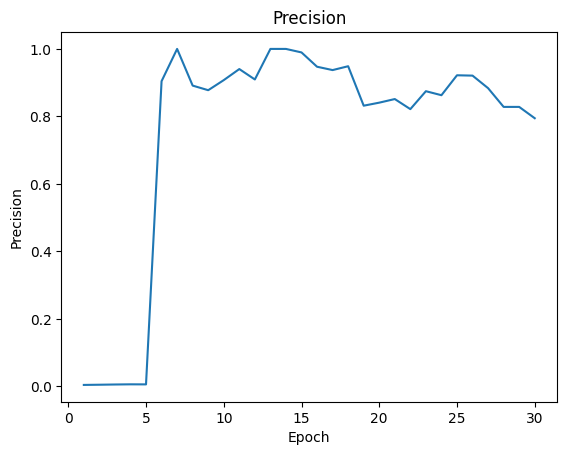

In [43]:
# Curva de precision conn matplotlib
plt.figure()
plt.plot(df['epoch'], df['metrics/precision(B)'])
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
# promedio precision
print("Precision promedio: ", df['metrics/precision(B)'].mean())

Recall promedio:  0.29063633333333333


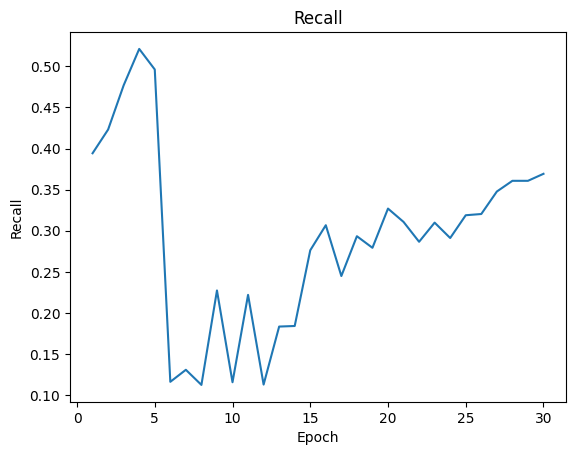

In [44]:
# CURVA DE RECALL
plt.figure()
plt.plot(df['epoch'], df['metrics/recall(B)'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')

#Promedio recall
print("Recall promedio: ", df['metrics/recall(B)'].mean())

 VAL Box Loss promedio:  1.5979483333333335


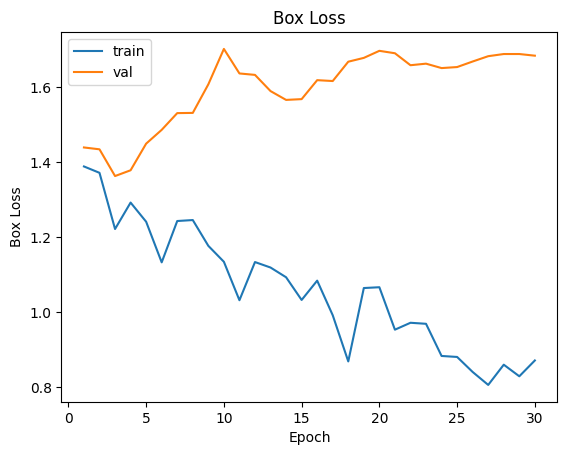

In [50]:
# gRAFICA BOX_LOSS
# Que tanto se equivoco el modelo al dibujar la caja del objeto
plt.figure()
plt.plot(df['epoch'], df['train/box_loss'],label = 'train')
plt.plot(df['epoch'], df['val/box_loss'],label = 'val')

plt.title('Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()

#Promedio val/boxloss
print(" VAL Box Loss promedio: ", df['val/box_loss'].mean())

Text(0, 0.5, 'Classification Loss')

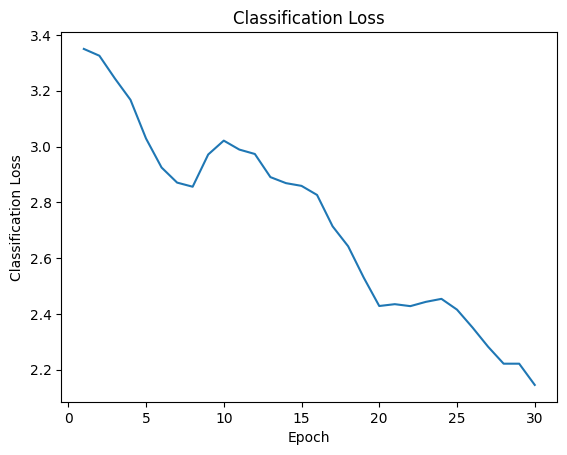

In [39]:
# Grafica de cls_box
# Que tanto se equivoco el modelo al clasificar
plt.figure()
plt.plot(df['epoch'], df['val/cls_loss'])
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')

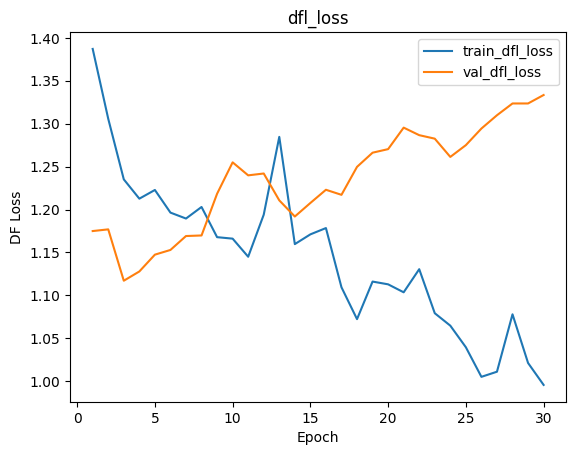

In [41]:
# grafica train/dfl_loss vs val/dfl1_loss
#Error en la predicción de las coordenadas (detalles finos)
plt.figure()
plt.plot(df['epoch'], df['train/dfl_loss'], label='train_dfl_loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='val_dfl_loss')
plt.title('dfl_loss')
plt.xlabel('Epoch')
plt.ylabel('DF Loss')
plt.legend()

Text(0, 0.5, 'mAP50')

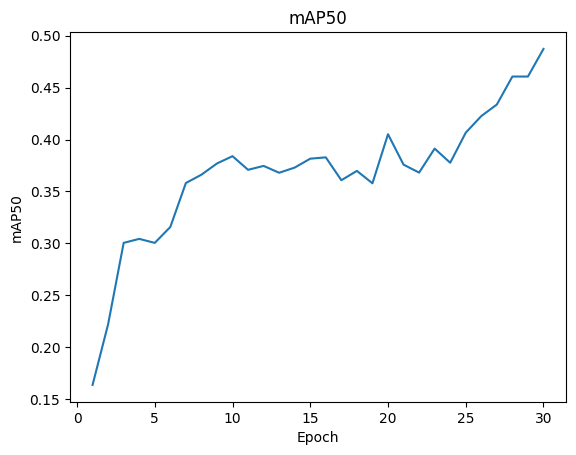

In [42]:
# Grafica de mAP50
#Precisión media cuando la intersección es al menos 50% (IoU)
plt.figure()
plt.plot(df['epoch'], df['metrics/mAP50(B)'])
plt.title('mAP50')
plt.xlabel('Epoch')
plt.ylabel('mAP50')

mAP50-95 promedio:  0.2294266666666666


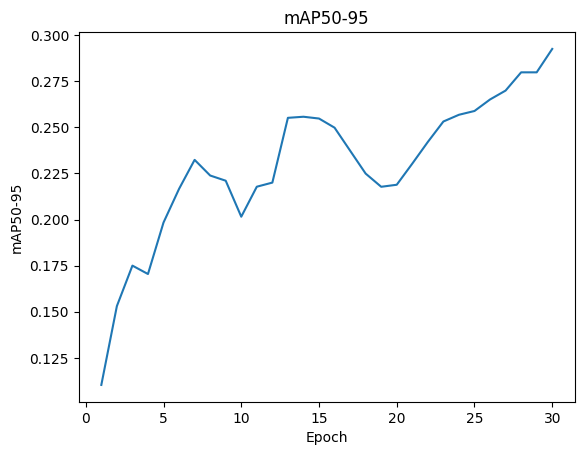

In [46]:
# Grafica de mAP50-95
plt.figure()
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'])
plt.title('mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP50-95')

#Promedio
print("mAP50-95 promedio: ", df['metrics/mAP50-95(B)'].mean())

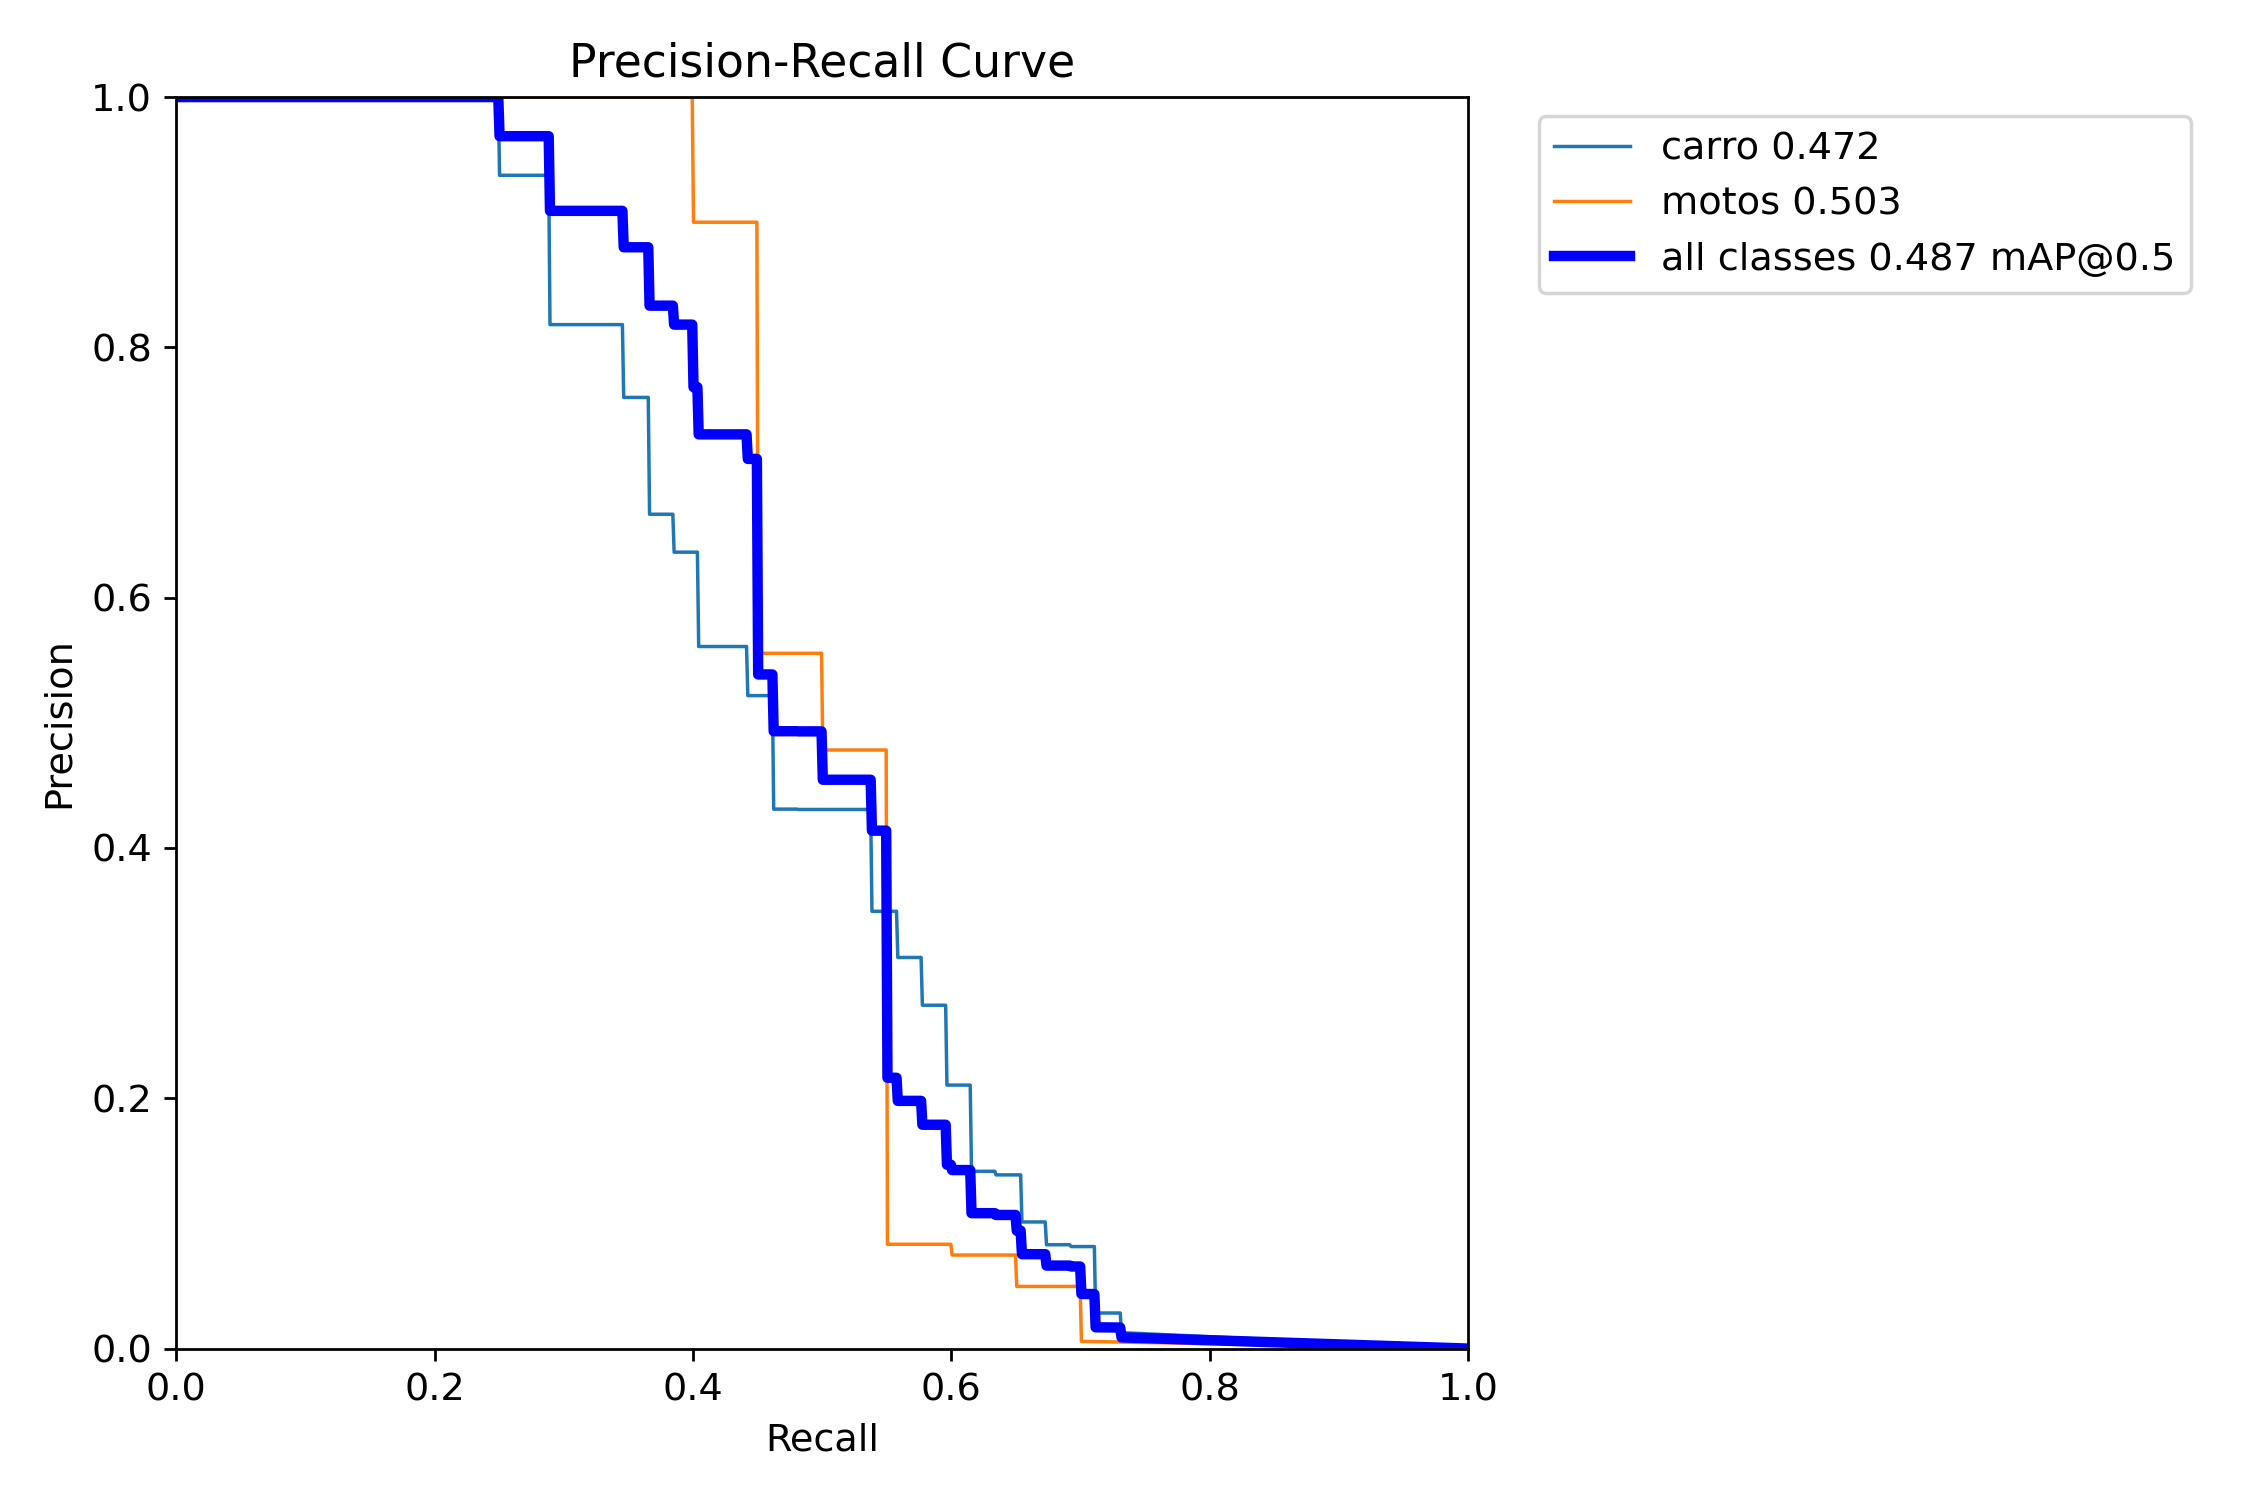

In [33]:
# 📸 Ver curvas
PR_curve = Image.open("runs/detect/train/PR_curve.png")
display(PR_curve)

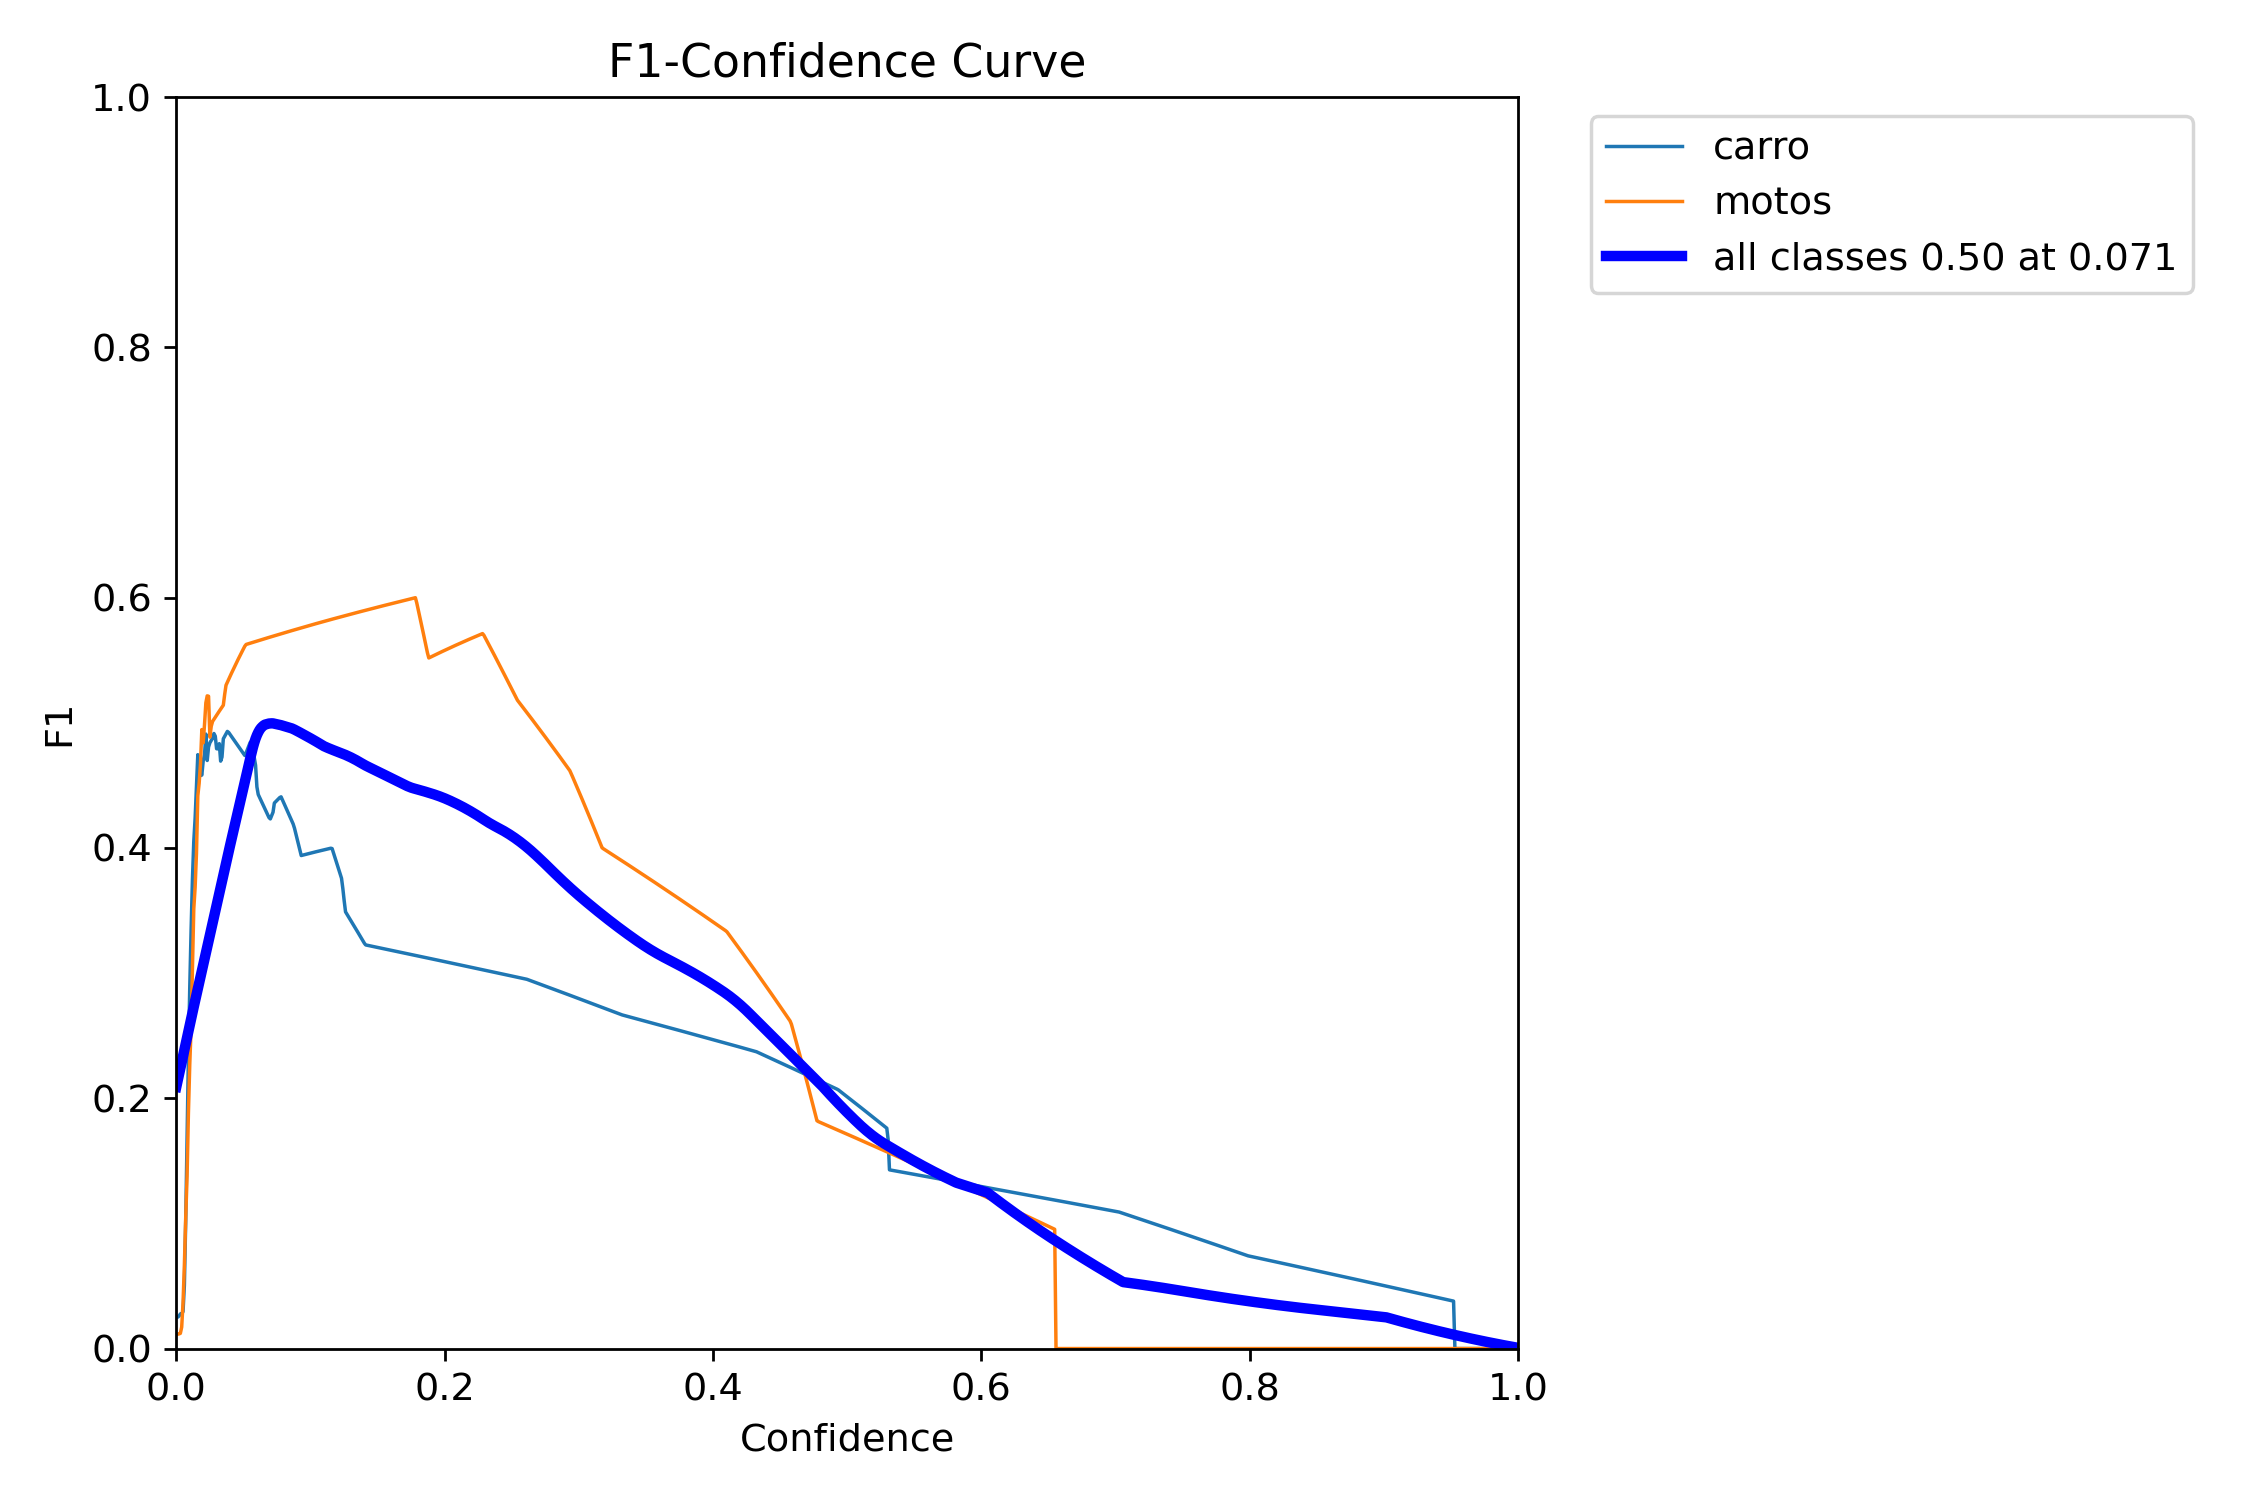

In [51]:
# F1 Curve
#Saber que tan bien esta equilibrado precision  y recall
# 0 malo , 1 bueno
F1_curve = Image.open("runs/detect/train/F1_curve.png")
display(F1_curve)

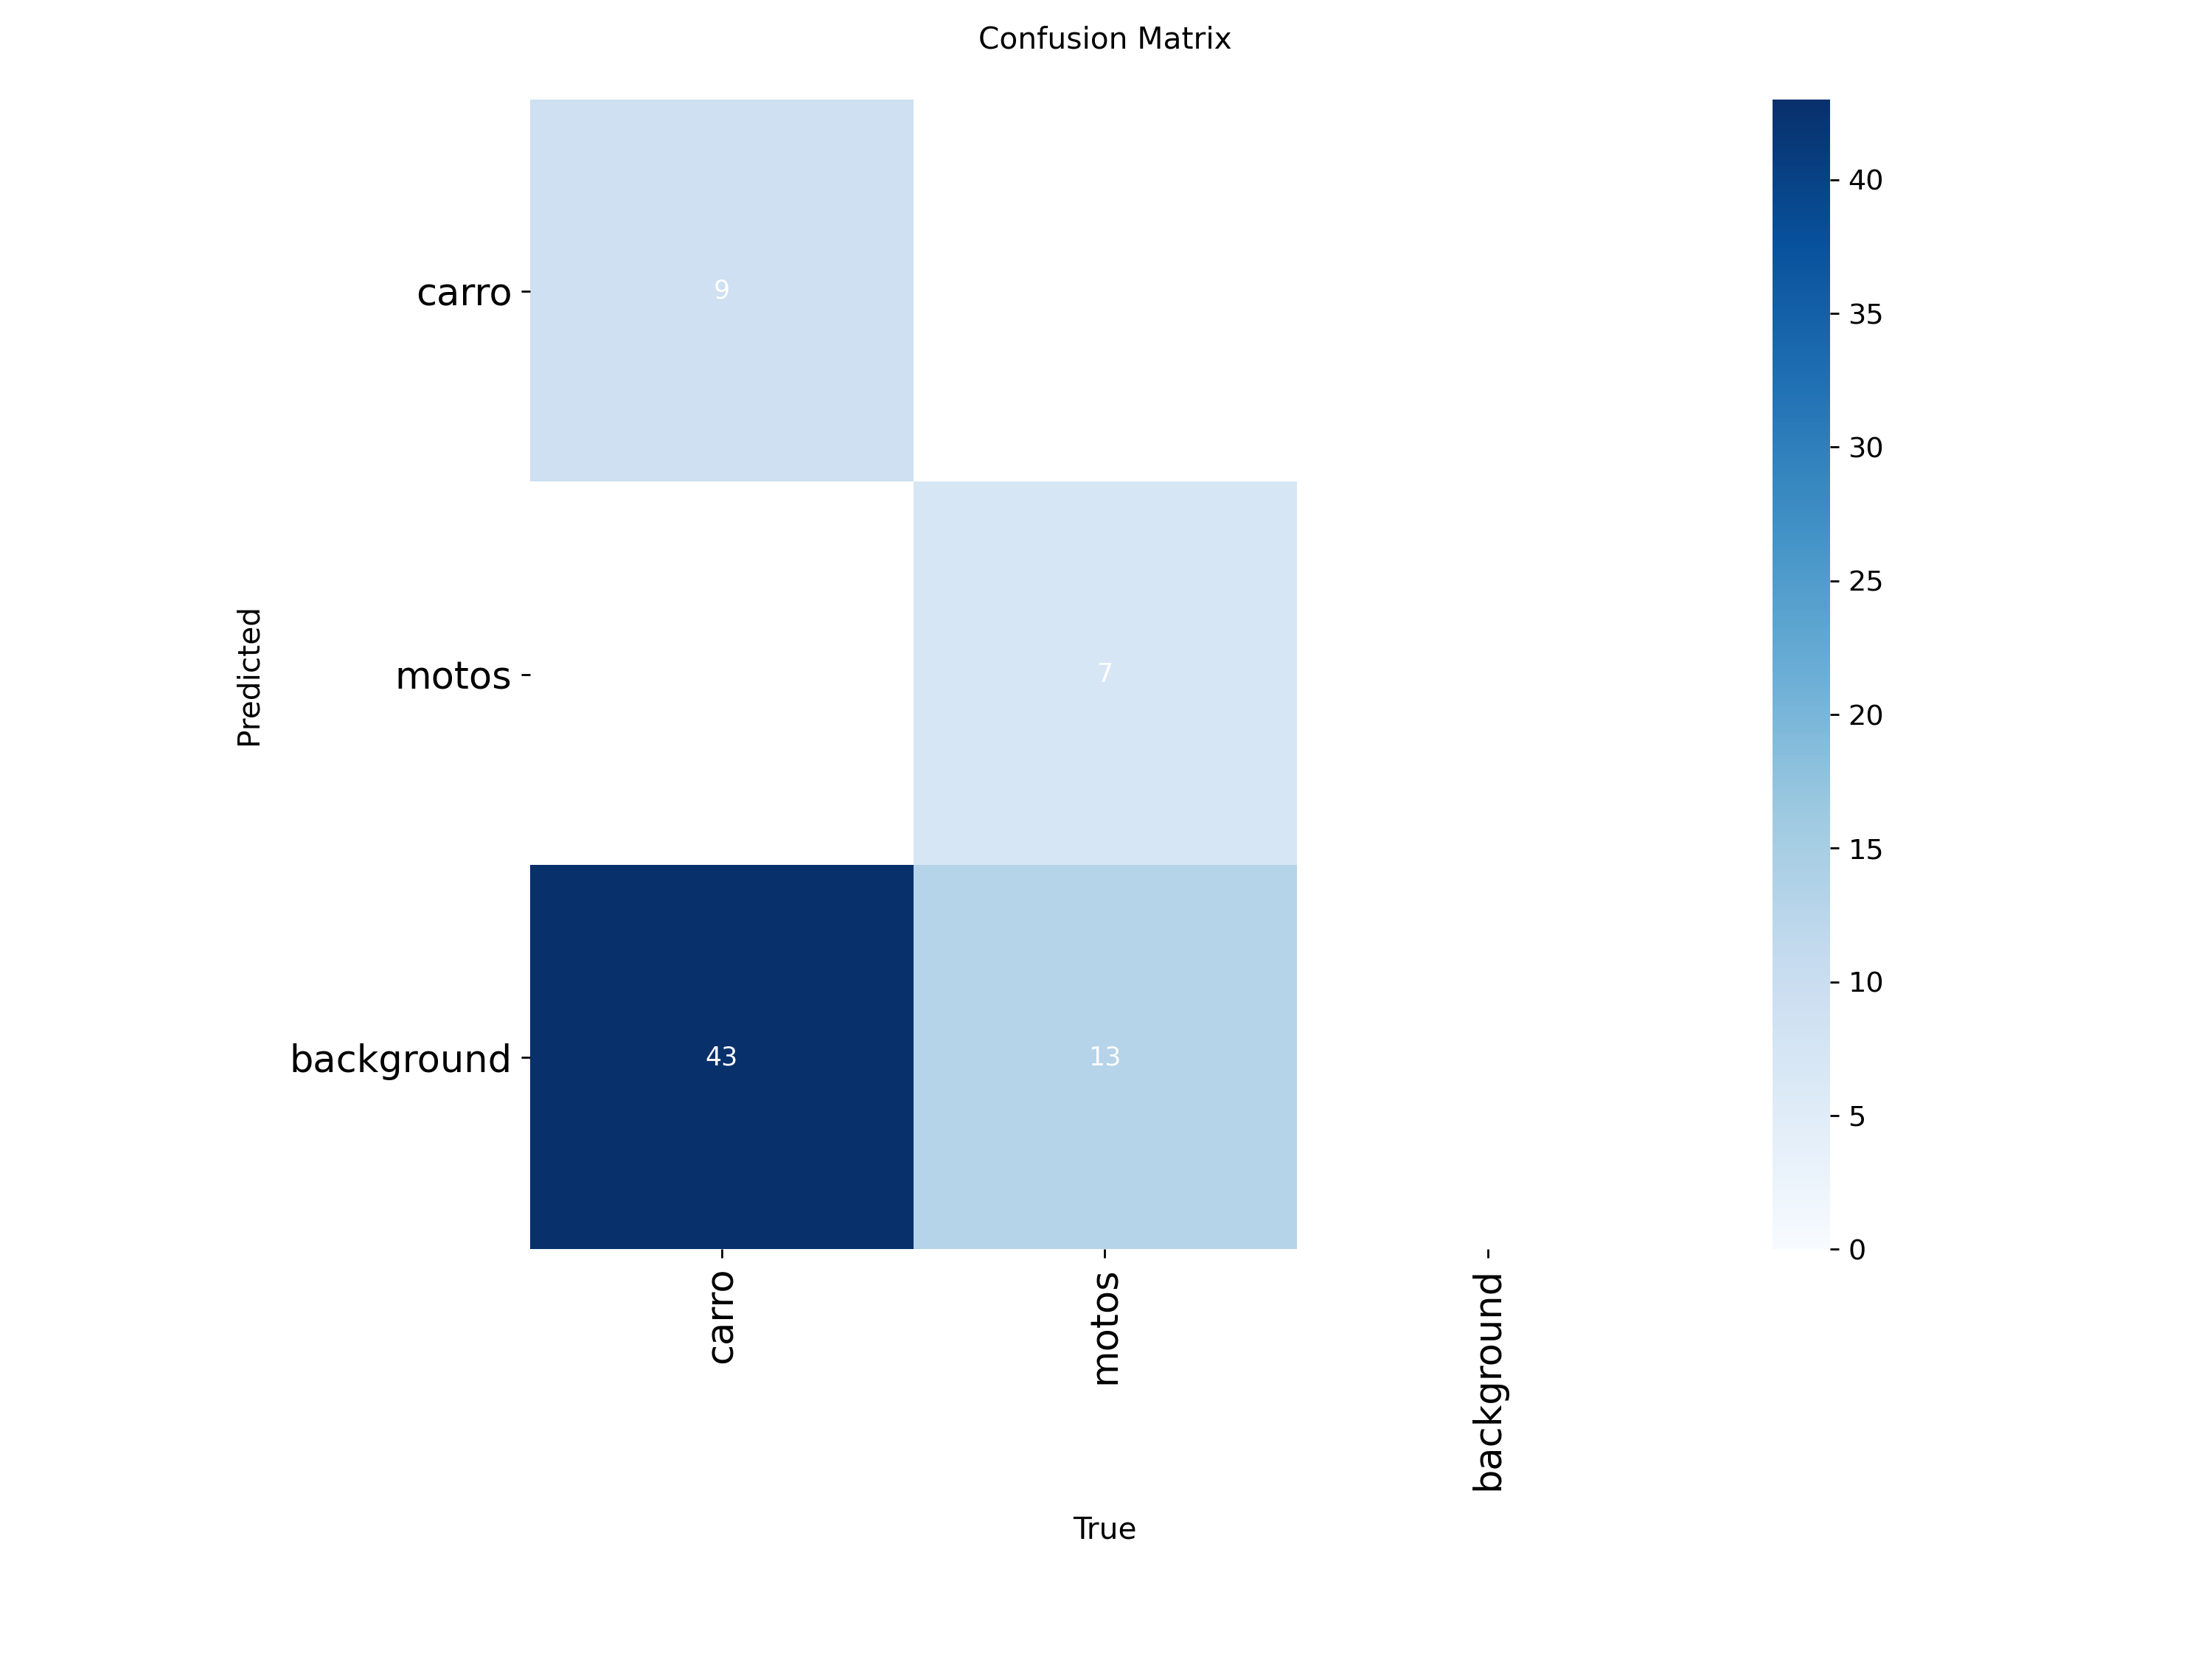

In [52]:
# Grafica matriz de cinfusion
confusion_matrix = Image.open("runs/detect/train/confusion_matrix.png")
display(confusion_matrix)

In [ ]:
# Evaluar
model.val()

# Mostrar predicción
results = model.predict(source="yolo_dataset/images/val", save=True, conf=0.3)
